# Notebook 1 - Simple Analyzer

This notebook takes CMS OpenData nanoAOD files, applies some selection and make few simple plots. 

Let's first load the libraries:

In [74]:
import asyncio
import logging
import os
import time

import vector; vector.register_awkward()
import awkward as ak
from coffea import processor
from coffea.nanoevents import transforms
from coffea.nanoevents.methods import base, vector
from coffea.nanoevents import NanoAODSchema
import hist
import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import uproot

For future use, let's define some global configuration

In [49]:
### GLOBAL CONFIGURATION

# input files per process, set to e.g. 10 (smaller number = faster)
N_FILES_MAX_PER_SAMPLE = 5

### BENCHMARKING-SPECIFIC SETTINGS

# chunk size to use
CHUNKSIZE = 500_000

# metadata to propagate through to metrics
CORES_PER_WORKER = 2  # does not do anything, only used for metric gathering (set to 2 for distributed coffea-casa)

# scaling for local setups with FuturesExecutor
NUM_CORES = 4

# only I/O, all other processing disabled
DISABLE_PROCESSING = False

# read additional branches (only with DISABLE_PROCESSING = True)
# acceptable values are 2.7, 4, 15, 25, 50 (corresponding to % of file read), 2.7% corresponds to the standard branches used in the notebook
IO_FILE_PERCENT = 2.7

NanoAOD datasets are stored in `data/ntuples_nanoaod.json` folder. This json file contains information about the number of events, process and systematic. The following function reads the json file and returns a dictionary with the process to run.

In [48]:
def construct_fileset(n_files_max_per_sample, 
                      use_xcache=False, 
                      onlyNominal=False,
                      ntuples_json="ntuples_nanoaod.json"):
    # using https://atlas-groupdata.web.cern.ch/atlas-groupdata/dev/AnalysisTop/TopDataPreparation/XSection-MC15-13TeV.data
    # for reference
    # x-secs are in pb
    xsec_info = {
        "ttbar": 396.87 + 332.97, # nonallhad + allhad, keep same x-sec for all
        "single_top_s_chan": 2.0268 + 1.2676,
        "single_top_t_chan": (36.993 + 22.175)/0.252,  # scale from lepton filter to inclusive
        "single_top_tW": 37.936 + 37.906,
        "wjets": 61457 * 0.252,  # e/mu+nu final states
        "data": None
    }

    # list of files
    with open(ntuples_json) as f:
        file_info = json.load(f)

    # process into "fileset" summarizing all info
    fileset = {}
    for process in file_info.keys():
        if process == "data":
            continue  # skip data

        for variation in file_info[process].keys():
            if onlyNominal & ~variation.startswith("nominal"): continue
            print(variation)
            file_list = file_info[process][variation]["files"]
            if n_files_max_per_sample != -1:
                file_list = file_list[:n_files_max_per_sample]  # use partial set of samples

            file_paths = [f["path"] for f in file_list]
            nevts_total = sum([f["nevts"] for f in file_list])
            metadata = {"process": process, "variation": variation, "nevts": nevts_total, "xsec": xsec_info[process]}
            fileset.update({f"{process}__{variation}": {"files": file_paths, "metadata": metadata}})

    return fileset


In [51]:
fileset = construct_fileset(N_FILES_MAX_PER_SAMPLE, use_xcache=False, 
                            onlyNominal=True, ntuples_json='../data/ntuples_nanoaod.json') 

print(f"processes in fileset: {list(fileset.keys())}")
print(f"\nexample of information in fileset:\n{{\n  'files': [{fileset['ttbar__nominal']['files'][0]}, ...],")
print(f"  'metadata': {fileset['ttbar__nominal']['metadata']}\n}}")

nominal
nominal
nominal
nominal
nominal
processes in fileset: ['ttbar__nominal', 'single_top_s_chan__nominal', 'single_top_t_chan__nominal', 'single_top_tW__nominal', 'wjets__nominal']

example of information in fileset:
{
  'files': [https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root, ...],
  'metadata': {'process': 'ttbar', 'variation': 'nominal', 'nevts': 6389801, 'xsec': 729.84}
}


## Analyzer

Here is the main analyzer. Uses coffea/awkward to make the analysis.

In [63]:
class TtbarAnalysis(processor.ProcessorABC):
    def __init__(self, disable_processing, io_file_percent):
        num_bins = 25
        bin_low = 50
        bin_high = 550
        name = "observable"
        label = "observable [GeV]"
        self.hist = (
            hist.Hist.new.Reg(num_bins, bin_low, bin_high, name=name, label=label)
            .StrCat(["4j1b", "4j2b"], name="region", label="Region")
            .StrCat([], name="process", label="Process", growth=True)
            .StrCat([], name="variation", label="Systematic variation", growth=True)
            .Weight()
        )
        self.disable_processing = disable_processing
        self.io_file_percent = io_file_percent

    def only_do_IO(self, events):
        # standard AGC branches cover 2.7% of the data
            branches_to_read = []
            if self.io_file_percent >= 2.7:
                branches_to_read.extend(["Jet_pt", "Jet_eta", "Jet_phi", "Jet_btagCSVV2", "Jet_mass", "Muon_pt", "Electron_pt"])
            
            if self.io_file_percent >= 4:
                branches_to_read.extend(["Electron_phi", "Electron_eta","Electron_mass","Muon_phi","Muon_eta","Muon_mass",
                                         "Photon_pt","Photon_eta","Photon_mass","Jet_jetId"])
            
            if self.io_file_percent>=15:
                branches_to_read.extend(["Jet_nConstituents","Jet_electronIdx1","Jet_electronIdx2","Jet_muonIdx1","Jet_muonIdx2",
                                         "Jet_chHEF","Jet_area","Jet_puId","Jet_qgl","Jet_btagDeepB","Jet_btagDeepCvB",
                                         "Jet_btagDeepCvL","Jet_btagDeepFlavB","Jet_btagDeepFlavCvB","Jet_btagDeepFlavCvL",
                                         "Jet_btagDeepFlavQG","Jet_chEmEF","Jet_chFPV0EF","Jet_muEF","Jet_muonSubtrFactor",
                                         "Jet_neEmEF","Jet_neHEF","Jet_puIdDisc"])
            
            if self.io_file_percent>=25:
                branches_to_read.extend(["Jet_rawFactor","Jet_bRegCorr","Jet_bRegRes","Jet_cRegCorr","Jet_cRegRes","Jet_nElectrons",
                                         "Jet_nMuons","GenJet_pt","GenJet_eta","GenJet_phi","GenJet_mass","Tau_pt","Tau_eta","Tau_mass",
                                         "Tau_phi","Muon_dxy","Muon_dxyErr","Muon_dxybs","Muon_dz","Muon_dzErr","Electron_dxy",
                                         "Electron_dxyErr","Electron_dz","Electron_dzErr","Electron_eInvMinusPInv","Electron_energyErr",
                                         "Electron_hoe","Electron_ip3d","Electron_jetPtRelv2","Electron_jetRelIso",
                                         "Electron_miniPFRelIso_all","Electron_miniPFRelIso_chg","Electron_mvaFall17V2Iso",
                                         "Electron_mvaFall17V2noIso","Electron_pfRelIso03_all","Electron_pfRelIso03_chg","Electron_r9",
                                         "Electron_scEtOverPt","Electron_sieie","Electron_sip3d","Electron_mvaTTH","Electron_charge",
                                         "Electron_cutBased","Electron_jetIdx","Electron_pdgId","Electron_photonIdx","Electron_tightCharge"])
            
            if self.io_file_percent==50:
                branches_to_read.extend(["GenPart_pt","GenPart_eta","GenPart_phi","GenPart_mass","GenPart_genPartIdxMother",
                                         "GenPart_pdgId","GenPart_status","GenPart_statusFlags"])
                
            if self.io_file_percent not in [2.7, 4, 15, 25, 50]:
                raise NotImplementedError("supported values for I/O percentage are 4, 15, 25, 50")
            
            for branch in branches_to_read:
                if "_" in branch:
                    split = branch.split("_")
                    object_type = split[0]
                    property_name = '_'.join(split[1:])
                    ak.materialized(events[object_type][property_name])
                else:
                    ak.materialized(events[branch])
            return {"hist": {}}

    def process(self, events):
        if self.disable_processing:
            # IO testing with no subsequent processing
            return self.only_do_IO(events)

        histogram = self.hist.copy()

        process = events.metadata["process"]  # "ttbar" etc.
        
        # normalization for MC
        x_sec = events.metadata["xsec"]
        nevts_total = events.metadata["nevts"]
        lumi = 3378 # /pb
        if process != "data":
            xsec_weight = x_sec * lumi / nevts_total
        else:
            xsec_weight = 1

        events["pt_nominal"] = 1.0

        ### event selection
        # very very loosely based on https://arxiv.org/abs/2006.13076

        # pT > 25 GeV for leptons & jets
        selected_electrons = events.Electron[events.Electron.pt > 25]
        selected_muons = events.Muon[events.Muon.pt > 25]
        jet_filter = events.Jet.pt * events["pt_nominal"] > 25  # pT > 25 GeV for jets (scaled by systematic variations)
        selected_jets = events.Jet[jet_filter]

        # single lepton requirement
        event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
        # at least four jets
        pt_var_modifier = events["pt_nominal"]
        event_filters = event_filters & (ak.count(selected_jets.pt * pt_var_modifier, axis=1) >= 4)
        # at least one b-tagged jet ("tag" means score above threshold)
        B_TAG_THRESHOLD = 0.5
        event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

        # apply event filters
        selected_events = events[event_filters]
        selected_electrons = selected_electrons[event_filters]
        selected_muons = selected_muons[event_filters]
        selected_jets = selected_jets[event_filters]

        for region in ["4j1b", "4j2b"]:
            # further filtering: 4j1b CR with single b-tag, 4j2b SR with two or more tags
            if region == "4j1b":
                region_filter = ak.sum(selected_jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) == 1
                selected_jets_region = selected_jets[region_filter]
                # use HT (scalar sum of jet pT) as observable
                pt_var_modifier = events[event_filters][region_filter]["pt_nominal"]
                observable = ak.sum(selected_jets_region.pt * pt_var_modifier, axis=-1)

            elif region == "4j2b":
                region_filter = ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2
                selected_jets_region = selected_jets[region_filter]

                # reconstruct hadronic top as bjj system with largest pT
                # the jet energy scale / resolution effect is not propagated to this observable at the moment
                trijet = ak.combinations(selected_jets_region, 3, fields=["j1", "j2", "j3"])  # trijet candidates
                trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # calculate four-momentum of tri-jet system
                trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
                trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
                # pick trijet candidate with largest pT and calculate mass of system
                trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
                observable = ak.flatten(trijet_mass)

            ### histogram filling
            
            # nominal pT, but including 2-point systematics
            histogram.fill(
                    observable=observable, region=region, process=process,
                    variation="nominal", weight=xsec_weight
                )

            
        output = {"nevents": {events.metadata["dataset"]: len(events)}, "hist": histogram}

        return output

    def postprocess(self, accumulator):
        return accumulator

Let's make it run:

In [75]:
executor = processor.FuturesExecutor(workers=NUM_CORES)

run = processor.Runner(executor=executor, schema=NanoAODSchema, 
                       savemetrics=True, metadata_cache={}, chunksize=CHUNKSIZE)

#filemeta = run.preprocess(fileset, treename="Events")  # pre-processing

t0 = time.monotonic()
all_histograms, metrics = run(fileset, "Events", processor_instance=TtbarAnalysis(DISABLE_PROCESSING, IO_FILE_PERCENT))  # processing
exec_time = time.monotonic() - t0
all_histograms = all_histograms["hist"]

AttributeError: 'Runner' object has no attribute 'preprocess'

In [73]:
#dataset_source = "/data" if fileset["ttbar__nominal"]["files"][0].startswith("/data") else "https://xrootd-local.unl.edu:1094" # TODO: xcache support
#metrics.update({"walltime": exec_time, "num_workers": NUM_CORES, "dataset_source": dataset_source, 
#                "n_files_max_per_sample": N_FILES_MAX_PER_SAMPLE, 
#                "cores_per_worker": CORES_PER_WORKER, "chunksize": CHUNKSIZE, "disable_processing": DISABLE_PROCESSING, "io_file_percent": IO_FILE_PERCENT})#

# save metrics to disk
#if not os.path.exists("metrics"):
#    os.makedirs("metrics")
#timestamp = time.strftime('%Y%m%d-%H%M%S')
#metric_file_name = f"metrics/nanoAOD-{AF_NAME}-{timestamp}.json"
#with open(metric_file_name, "w") as f:
#    f.write(json.dumps(metrics))

#print(f"metrics saved as {metric_file_name}")
#print(f"event rate per worker (full execution time divided by NUM_CORES={NUM_CORES}): {metrics['entries'] / NUM_CORES / exec_time / 1_000:.2f} kHz")
#print(f"event rate per worker (pure processtime): {metrics['entries'] / metrics['processtime'] / 1_000:.2f} kHz")
#print(f"amount of data read: {metrics['bytesread']/1000**2:.2f} MB")  # likely buggy: https://github.com/CoffeaTeam/coffea/issues/717


## Plots

Finally, let's make some simple plots:

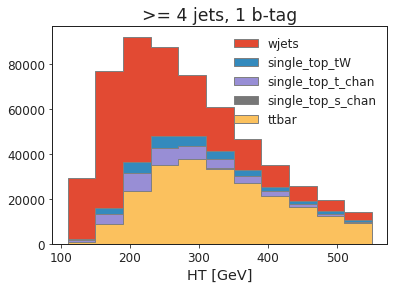

In [76]:
mpl.style.use("ggplot")
plt.rcParams["axes.facecolor"] = "none"
plt.rcParams["axes.edgecolor"] = "222222"
plt.rcParams["axes.labelcolor"] = "222222"
plt.rcParams["xtick.color"] = "222222"
plt.rcParams["ytick.color"] = "222222"
plt.rcParams["font.size"] = 12
plt.rcParams['text.color'] = "222222"

all_histograms[120j::hist.rebin(2), "4j1b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1, edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, 1 b-tag")
plt.xlabel("HT [GeV]");

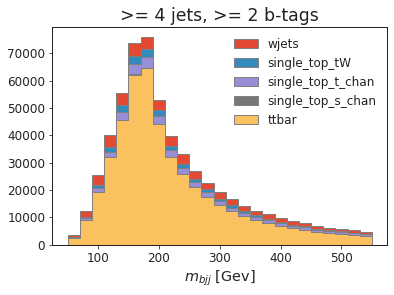

In [68]:
all_histograms[:, "4j2b", :, "nominal"].stack("process")[::-1].plot(stack=True, histtype="fill", linewidth=1,edgecolor="grey")
plt.legend(frameon=False)
plt.title(">= 4 jets, >= 2 b-tags")
plt.xlabel("$m_{bjj}$ [Gev]");

## 

In [71]:
def save_histograms(all_histograms, fileset, filename):
    nominal_samples = [sample for sample in fileset.keys() if "nominal" in sample]

    all_histograms += 1e-6  # add minimal event count to all bins to avoid crashes when processing a small number of samples

    #pseudo_data = (all_histograms[:, :, "ttbar", "ME_var"] + all_histograms[:, :, "ttbar", "PS_var"]) / 2  + all_histograms[:, :, "wjets", "nominal"]

    with uproot.recreate(filename) as f:
        for region in ["4j1b", "4j2b"]:
            #f[f"{region}_pseudodata"] = pseudo_data[120j::hist.rebin(2), region]
            for sample in nominal_samples:
                sample_name = sample.split("__")[0]
                f[f"{region}_{sample_name}"] = all_histograms[120j::hist.rebin(2), region, sample_name, "nominal"]

In [72]:
save_histograms(all_histograms, fileset, "histograms.root")